![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de las librerías requeridas para el desarrollo de las dos partes del taller
%matplotlib inline
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
plt.style.use('ggplot')

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
from sklearn.ensemble import BaggingClassifier, VotingClassifier

from collections import Counter

from graphviz import Source
from six import StringIO
import pydotplus
from IPython.display import Image 

In [3]:
#Se lee y se guarda en una estrucura de datos la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

#Se renombra la variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

#Se crea la hora como una variable 
bikes['hour'] = bikes.index.hour

#Se vizualizan las priemras 5 observaciones del dataframe.
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [21]:
# Celda 1.1
print(bikes.groupby('season').total.mean())
print(bikes.groupby('season').total.describe().T)

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64
season            1            2            3            4
count   2686.000000  2733.000000  2733.000000  2734.000000
mean     116.343261   215.251372   234.417124   198.988296
std      125.273974   192.007843   197.151001   177.622409
min        1.000000     1.000000     1.000000     1.000000
25%       24.000000    49.000000    68.000000    51.000000
50%       78.000000   172.000000   195.000000   161.000000
75%      164.000000   321.000000   347.000000   294.000000
max      801.000000   873.000000   977.000000   948.000000


#### Análisis Descriptivo Variable: _season_
La variable _season_ está compuesta por 4 categorías correspondientes a las estaciones del año: 1:Invierno, 2:Primavera, 3:Verano y  4:Otoño. Las estaciones con un promedio bajo de bicicletas rentadas, o lo mismo que usuarios, son otoño e invierno, siendo esta última, la más baja de todas. Por otro lado, las estaciones con un promedio alto de bicicletas rentadas son primavera y verano, siendo esta última, la mas alta de todas. Los resultados son coherentes, pues es de esperarse que se usen mucho más las biciletas en las estaciones con climas cálidos y soleados.

Por otro lado, se denota que los promedios o medias de las estaciones son mayores que los valores de sus correspondientes medianas, lo que indica que la distribución de las datos es sesgada a la derecha, es decir, con una concentración de los datos a la izquierda.

Finalmente, basados en el rango intercuartíl, el set de datos puede incluir muchos valores átipicos.

In [22]:
# Celda 1.2
print(bikes.groupby('hour').total.mean())
print(bikes.groupby('hour').total.describe().T)

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64
hour           0           1           2           3           4           5   \
count  455.000000  454.000000  448.000000  433.000000  442.000000  452.000000   
mean    55.138462   33.859031   22.899554   11.757506    6.407240   19.767699   
std     43.620012   34.112105   26.110267   12.666442    4.217633   12.784293   
min      2.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%     24.000000   11.000000    5.000000    3.000000    3.000000    8.000000   
50%     41.000000   19.000000   11.000000    6.000000    6.000000   19.00

#### Análisis Descriptivo Variable: _hour_
La variable _hour_ se puede enteneder como una variable numérica discreta entre 0 y 24. La hora del día con el promedio más bajo de bicicletas rentadas son las 4 de la mañana, mientras que las 5 de la tarde lo son para el promedio más alto, en la tarde, y las 8 de la mañana el promedio más alto en la mañana. Lo que corresponde con las horas pico del día relacionadas con la jornada laboral.

A diferencia de las estaciones, los promedios o medias de las horas son muy cercanas los valores de sus correspondientes medianas, lo que indica que la distribución de las datos es muy similar a una distribución normal. 

Finalmente, de acuerdo con los rangos intercuatiles, el set de datos podría tener muchos valores atípicos.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

Text(0.5, 1.0, 'Renta Promedio por Hora')

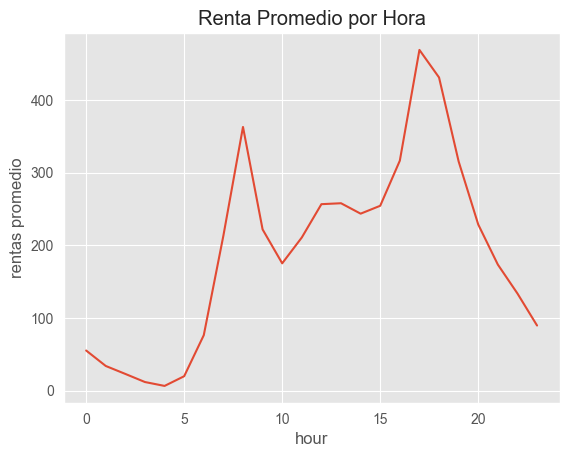

In [26]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()
plt.ylabel('rentas promedio')
plt.title('Renta Promedio de Bicicletas por Hora')

Text(0.5, 1.0, 'Renta Promedio de Bicicletas por Hora en Invierno')

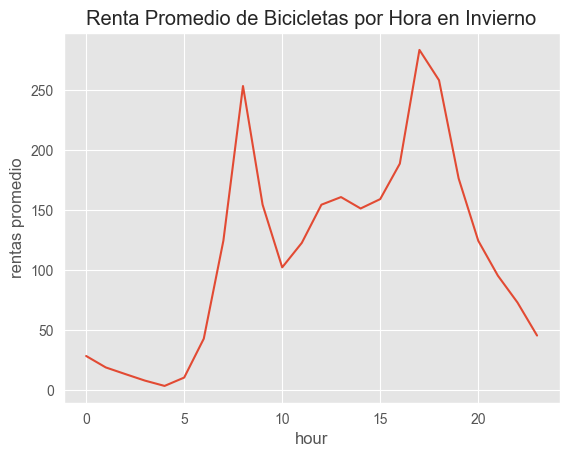

In [27]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes[bikes['season']== 1].groupby('hour').total.mean().plot()
plt.ylabel('rentas promedio')
plt.title('Renta Promedio de Bicicletas por Hora en Invierno')

Text(0.5, 1.0, 'Renta Promedio de Bicicletas por Hora en Verano')

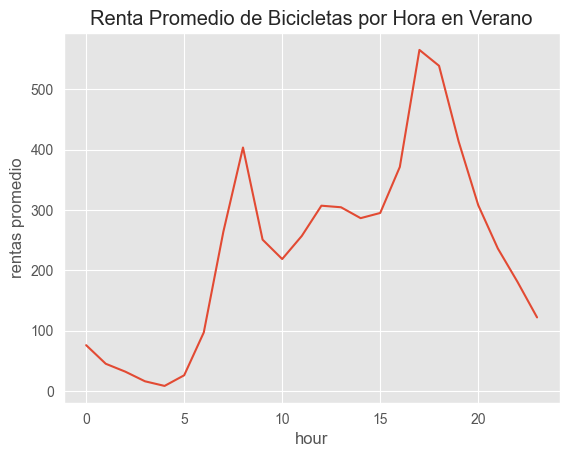

In [28]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes[bikes['season']== 3].groupby('hour').total.mean().plot()
plt.ylabel('rentas promedio')
plt.title('Renta Promedio de Bicicletas por Hora en Verano')

#### Análisis de Resultados de la Agrupación Estacion-Hora (_season-hour_)
En general, y como fue descrito en el análisis descriptivo,la renta promedio de bicicletas tiene su mínimo en la madrugada (4AM es la hora con menos usuarios promedio) y tres picos de acuerdo con el horario laboral, a las 8AM (hora de inicio de la jornada laboral), un segundo a la 1PM (hora del almuerzo) y finalmente, un tercero a las 5PM (máximo a la hora de la finalización de la jornada).

Adicionalmente, se puede inferir que la tendencia o patrón es similar para la estación con más bajo promedio de renta de bicicletas (invierno) y para la estaiñon con mñas alto ppromedio de renta de bicicletas (verano). Con una difeerencia en la proporción de usarios en hora-pico-mañana/hora-pico-tarde, la cual es más cercana a uno para invierno (0.83 aprox.) que para verano (0.67 aprox.)

Finalmente, se entiende que en invierno, el promedio máximo de usuarios es cercano a 300, mientras que en verano es cercano a los 600.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [29]:
# Celda 3
X_reg = bikes[['hour', 'season']]
X_reg = pd.get_dummies(X_reg, columns=['season'], drop_first=True)
y_reg = bikes.total
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.33, random_state=17)

model_lr = LinearRegression()
model_lr.fit(X_train,y_train)
pred_lr = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test,pred_lr)

print(f'MSE Linear Regression: {mse_lr:,.3f}')
print(f'Intercepto: {model_lr.intercept_}')
print(f'Coeficientes: {model_lr.coef_}')

MSE Linear Regression: 26,199.779
Intercepto: -3.2205040200592805
Coeficientes: [ 10.27628457  96.65905569 118.67915305  80.17254022]


#### Análisis de Resultados del Modelo de Regresión Lineal - Varibles de Entrada: _season: cat, hour: num_

- Interpretación de Coeficientes: De acuerdo con los coefientes que acompañan cada una de las variables de entrada (hora, primavera, verano, otoño), se entiende que el modelo de regresión de lineal predice el número de usuarios mediante el producto entre 10.3 y la hora del día en invierno, para primavera a este producto se le debe sumar aproximadamente 96.66, mientras que para verano u otoño, se debe sumar 118.68 o 80.17 respectivamente.

- Limitación del Modelo de Regresión Lineal: La gran limitación de este modelo es que el hiperplano formado no representa los máximos y mínimos formados por la demanda que se rige por las horas pico durante la jornada, lo que resulta en un poder de predicción muy bajo.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [30]:
# Celda 4

#Se definen de las variables independientes y dependiente
X_dt = bikes[['hour', 'season']]
y_dt = bikes.total

#Se declaran las funciones de ayuda para determinar el desempeño del nodo y su mejor partición.

def gini(y):
    '''Esta función calcula el factor Gini de un hoja.
    '''
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)
    
def gini_impurity(X_col, y, split):
    '''Esta función calcula el Gini Total o impureza de un nodo.
    '''
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

def best_split(X, y, num_pct=10):
    '''Esta función calcula la mejor partición de acuerdo con el cálculo del factor Gini Total. 
    '''
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]

    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0/(num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

#Se define la función para creación del árbol de decisión.

def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    #Condicional para cuando solo es una observación.
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    #Se calcula la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    #Se guarda el arbol de decisión y se estima ek set de predicciones.
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    #Se revisan los criterios de parada: máxima profundidad y ganancia mínima.
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Se continua con las particiones.
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Se itera para cada partición.
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

# Se ejecuta la función para crecer el arbol de decisión.
tree_grow(X_dt, y_dt, level=0, min_gain=0.001, max_depth=3, num_pct=10)

{'y_pred': 1,
 'y_prob': 191.53903379867745,
 'level': 0,
 'split': [0, 8.0],
 'n_samples': 10886,
 'gain': 18268.811823533004,
 'sl': {'y_pred': 1,
  'y_prob': 55.40711902113459,
  'level': 1,
  'split': [0, 7.0],
  'n_samples': 3594,
  'gain': 7207.700659959655,
  'sl': {'y_pred': 1,
   'y_prob': 32.561604584527224,
   'level': 2,
   'split': [0, 6.0],
   'n_samples': 3139,
   'gain': 646.8008927589567,
   'sl': {'y_pred': 1,
    'y_prob': 25.15934475055845,
    'level': 3,
    'split': -1,
    'n_samples': 2684,
    'gain': 382.8088308604629},
   'sr': {'y_pred': 1,
    'y_prob': 75.92778993435448,
    'level': 3,
    'split': -1,
    'n_samples': 455,
    'gain': 743.095592335012}},
  'sr': {'y_pred': 1,
   'y_prob': 212.18599562363238,
   'level': 2,
   'split': [1, 2.0],
   'n_samples': 455,
   'gain': 5197.1071057533845,
   'sl': {'y_pred': 1,
    'y_prob': 122.27826086956522,
    'level': 3,
    'split': -1,
    'n_samples': 113,
    'gain': 0},
   'sr': {'y_pred': 1,
    'y_pr

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

(-15374.840674066669, 6)
MSE Decision Tree (Regressor): 13,321.059


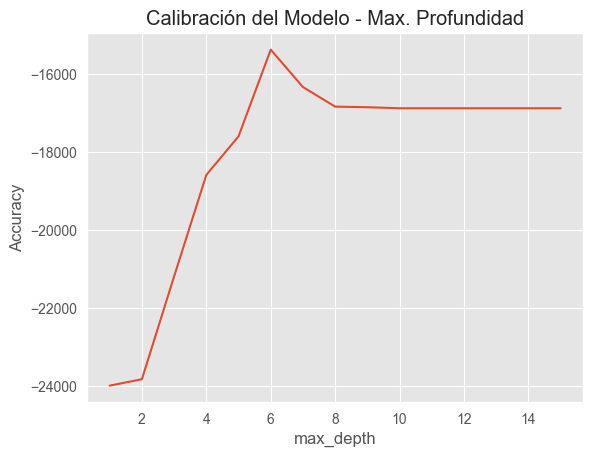

In [36]:
# Celda 5
X_Train, X_Test, y_Train, y_Test = train_test_split(X_dt, y_dt, test_size=0.33, random_state=17)

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 16)

# Lista para guardar los valores del MSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión 
    clf = DecisionTreeRegressor(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_dt, y_dt, cv=10, scoring='neg_mean_squared_error', n_jobs=-1).mean())

# Gráfica max_depth versus MSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Calibración del Modelo - Max. Profundidad')

print(sorted(zip(accuracy_scores, max_depth_range))[::-1][0])

dt_reg = DecisionTreeRegressor(max_depth=6, random_state=1)
dt_reg.fit(X_Train, y_Train)

# Predicción
y_Pred = dt_reg.predict(X_Test)

# Error MSE del modelo
mse_dt_reg = mean_squared_error(y_Test, y_Pred)
print(f'MSE Decision Tree (Regressor): {mse_dt_reg:,.3f}')

#### Análisis de Resultados del Modelo de Árbol de Decisión - Varibles de Entrada: _season: cat, hour: num_

- Desempeño del Modelo: El MSE fue escogido como una métrica para medir el desempeño en modelos de regresión.

- Criterio de Calibración: Para la calibración del modelo se escogió la profundidad máxima de árbol. Los resultados determinaron que con una profundidad máxima de 6 se obtiene el MSE más bajo. 

- Comparación de los Modelos Reg. Lineal-Arbol de Decisión: Por si solo, el MSE del modelo no refencia un nivel de desempeño. Sin embargo, al usarlo como métrica de comparación entre modelos, en este caso entre el modelo de regresión lineal obtenido en el Punto 3 (MSE: 26,199.779) y el modelo de arbol de decisión obtenido en el punto 5 (MSE: 13,321.059) se puede determinar que el modelo de Arbol de Decisión tiene un error MSE mucho más bajo que el modelo de regresión lineal, haciendo del primero, un modelo con más poder predictivo.

- Modelo ärbol de Decisión: El modelo del árbol de decisión entrenado en el punto 5 se ilustra en la celda enseguida.

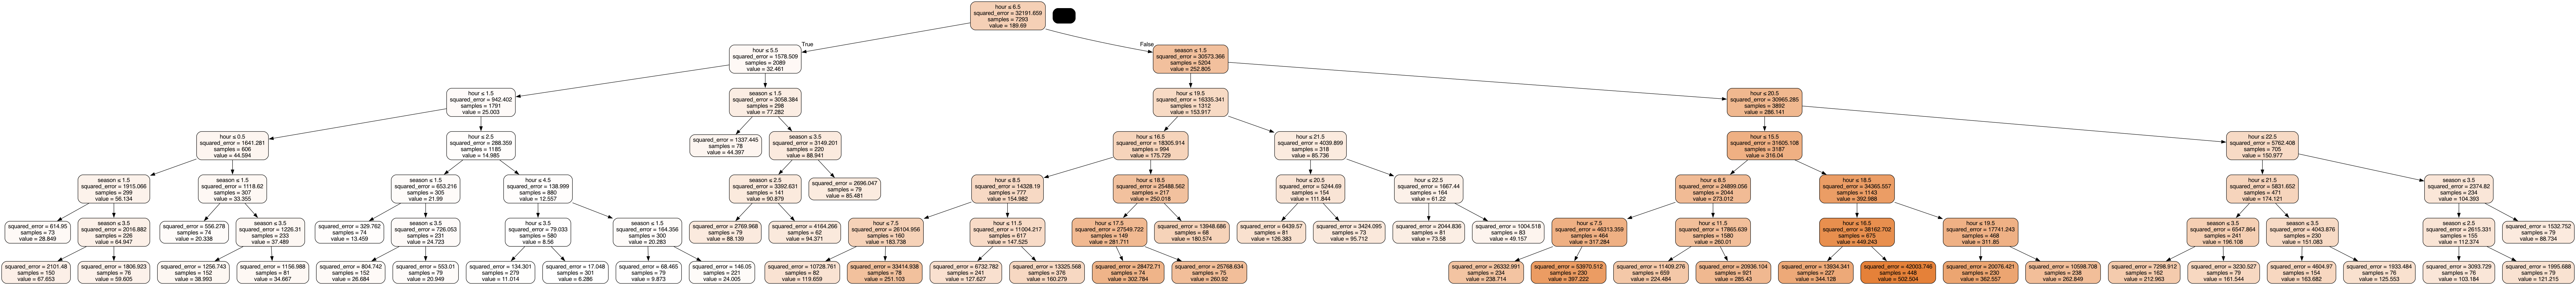

In [32]:
#Arbol de decisión entrenado en el Punto 5.
dot_data = StringIO()
export_graphviz(dt_reg, out_file=dot_data, feature_names=X_dt.columns, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [3]:
#Se lee y se guarda en una estrucura de datos la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [6]:
#Se define la variable de interes y las variables predictoras, sus dimensiones y el balance de la variable de interes.
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
print(y.mean())

print(X.shape, y.shape)
print(f"Distribución de la Variable Dependiente - Popular: {Counter(y)}")

0.5
(6000, 59) (6000,)
Distribución de la Variable Dependiente - Popular: Counter({1: 3000, 0: 3000})


In [7]:
#Se determinan las muestras de entrenamiento y prueba del set de datos y sus dimensiones
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

#Se estándarizan los datos de las muestra de entrenamiento y prueba
scaler = StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

print(X_train.shape, X_test.shape)

(4020, 59) (1980, 59)


### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [56]:
# Celda 6

#Se define la lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 16)

#Se define la lista para guardar los valores de la métrica F1 Score para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

#Se define el loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión
    clf = DecisionTreeClassifier(max_depth=depth, max_features="sqrt", random_state=37)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='f1', n_jobs=-1).mean())

print(sorted(zip(accuracy_scores, max_depth_range))[::-1][0])

dt_clf = DecisionTreeClassifier(max_depth=3, max_features="sqrt", random_state=17)
dt_clf.fit(X_train, y_train)

#Se calcula la predicción
y_pred = dt_clf.predict(X_test)

# Se calcula el error del modelo
f1_dt_clf, acc_dt_clf = f1_score(y_test, y_pred),accuracy_score(y_test, y_pred)
print(f'F1 Score - Decision Tree (Classifier): {f1_dt_clf:,.3f}')
print(f'Accuracy - Decision Tree (Classifier): {acc_dt_clf:,.3f}')

(0.6493722815082312, 3)
F1 Score - Decision Tree (Classifier): 0.648
Accuracy - Decision Tree (Classifier): 0.623


In [57]:
#Se entrena un modelo de regresión logística
logit = LogisticRegression(n_jobs=-1, random_state=17)
logit.fit(X_train, y_train)

#Se estiman las predicciones del modelo de regresión
y_pred = logit.predict(X_test)

# Se calcula el error del modelo
f1_logit, acc_logit = f1_score(y_test, y_pred), accuracy_score(y_test, y_pred)  
print(f'F1 Score - Logistic Regression: {f1_logit:,.3f}')
print(f'Accuracy - Logistic Regression: {acc_logit:,.3f}')

F1 Score - Logistic Regression: 0.636
Accuracy - Logistic Regression: 0.645


#### Análisis de Resultados del Modelo de Clasificación usando Árbol de Decisión y Regresión Logística. 

- Desempeño del Modelo: De acuerdo con el enunciado, F1 Score y Accuracy fueron escogidos como las métricas para medir el desempeño en modelos de clasificación

- Criterio de Calibración: Para la calibración del modelo árbol de decisión se escogió la profundidad máxima de árbol. Los resultados determinaron que con una profundidad máxima de 3 se obtiene el F1 Score más alto. 

- Comparación de los Modelos Reg. Logística-Arbol de Decisión: La comparación de los modelos muestra que el modelo de clasificación usando un árbol de decisión tiene la métrica F1 Score de desempeño más alta que el modelo de regresión logitica; sin embargo, la métrica accuracy es más baja. Considerando que el set de datos tiene las clases balancedas, la métrica Accuracy quizas es más significativa, por lo que el modelo de regresión logística podría tener un mejor desempeño.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [10]:
#Se calibra un modelo de arbol de decisión de acuerdo con el parámetro min_samples_leaf
min_samples_leaf = range(1, 5)

#Se define la lista para guardar los valores del F1 Score para cada valor del mínimo de muestras por hoja (min_samples_leaf)
accuracy_scores = []

#Se define el loop para obtener el desempeño del modelo de acuerdo con el mínimo de muestras por hoja
for leaf in min_samples_leaf:
    # Definición del árbol de decisión 
    clf = DecisionTreeClassifier(min_samples_leaf= leaf, max_features="sqrt", random_state=37)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='f1', n_jobs=-1).mean())

print(sorted(zip(accuracy_scores, min_samples_leaf))[::-1][0])

(0.5638943083233989, 1)


In [11]:
# Celda 7

#Se definen los tres modelos base de acuerdo con el enunciado del caso.
dt_d = DecisionTreeClassifier(max_depth=3, max_features="sqrt", random_state=37)
dt_l = DecisionTreeClassifier(min_samples_leaf=1, max_features="sqrt", random_state=37)
logit_bag = LogisticRegression(n_jobs=-1, random_state=17, max_iter=5000)

#Se entrenan 100 modelos de cada modelo base usando el método de ensamble Bagging
clf_dtd = BaggingClassifier(estimator=dt_d, n_estimators=100, bootstrap=True,random_state=37, n_jobs=-1, oob_score=True)
clf_dtl = BaggingClassifier(estimator=dt_l, n_estimators=100, bootstrap=True,random_state=37, n_jobs=-1, oob_score=True)
clf_logit = BaggingClassifier(estimator=logit_bag, n_estimators=100, bootstrap=True,random_state=1, n_jobs=-1, oob_score=True)

#Se estiman las predicciones y se calculan las métricas de desempeño el ensamble de cada modelo base. Bagging emplea la votación mayoritaria para cada modelo base.
for clf, label in zip([clf_dtd, clf_dtl, clf_logit], ['Decision Tree (max_depth=3)', 'Decision Tree (min_samples_leaf=1)', 'Logistic Regression']):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("F1 Score: %0.3f [%s]" % (f1_score(y_test, y_pred), label))
    print("Accuracy: %0.3f [%s]" % (accuracy_score(y_test, y_pred), label))

F1 Score: 0.653 [Decision Tree (max_depth=3)]
Accuracy: 0.660 [Decision Tree (max_depth=3)]
F1 Score: 0.662 [Decision Tree (min_samples_leaf=1)]
Accuracy: 0.659 [Decision Tree (min_samples_leaf=1)]
F1 Score: 0.636 [Logistic Regression]
Accuracy: 0.644 [Logistic Regression]


In [17]:
#Se ensamablan 300 modelos(100 modelos para cada modelo base) y se determinan las predicciones por votación mayoritaria (Bagging Heterogéneo).

n_estimators = 100
np.random.seed(17)

n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

seeds = np.random.randint(1, 10000, size=n_estimators)

#Se entrena y se estiman las predicciones para 100 modelos de árbol de decisión con un máximo de profundidad específico.
dt_dm = {}
for i in range(n_estimators):
    dt_dm[i] = DecisionTreeClassifier(max_features="sqrt", max_depth=3, random_state=seeds[i])
    dt_dm[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

y_pred_df1 = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df1.iloc[:, i] = dt_dm[i].predict(X_test)

#Se entrena y se estiman las predicciones para 100 modelos de árbol de decisión con un mínimo de muestras por hoja específico.
dt_lm = {}
for i in range(n_estimators):
    dt_lm[i] = DecisionTreeClassifier(min_samples_leaf=1,max_features="sqrt", max_depth=None, random_state=seeds[i])
    dt_lm[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

y_pred_df2 = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df2.iloc[:, i] = dt_lm[i].predict(X_test)

#Se entrena y se estiman las predicciones para 100 modelos de regresión logística.
logit_bagm = {}
for i in range(n_estimators):
    logit_bagm[i] = LogisticRegression(n_jobs=-1,max_iter=5000,random_state=seeds[i])
    logit_bagm[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

y_pred_df3 = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df3.iloc[:, i] = logit_bagm[i].predict(X_test)

#Se concatenan las predicciones de los 300 modelos en una sola matriz de predicciones.
y_pred_df = pd.concat([y_pred_df1, y_pred_df2, y_pred_df3], axis=1)

#Se define la predicción mediante votación mayoritaria.
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators*3 / 2)).astype(int)

#Se calculan las métricas de desempeño.
f1_ensamble, acc_ensamble = f1_score(y_test, y_pred), accuracy_score(y_test, y_pred)

print(f'F1 Score - Ensamble Votación Mayoritaria (300 modelos): {f1_ensamble:,.3f}')
print(f'Accuracy - Ensamble Votación Mayoritaria (300 modelos): {acc_ensamble:,.3f}')

F1 Score - Ensamble Votación Mayoritaria (300 modelos): 0.653
Accuracy - Ensamble Votación Mayoritaria (300 modelos): 0.660


#### Análisis de Resultados del Modelo de Clasificación usando el Ensamble por Votación Mayoritaria de Árbol de Decisión y Regresión Logística. 

La comparación de los modelos se hace por medio de las métricas calculadas. Para cada modelo, es decir para los 100 modelos de cada modelo base, las métricas muestran un mejor desempeño del modelo de ensamblaje Bagging para el modelo de árbol de decisión con una máxima profundidad, tanto al compararlo con el modelo entrenado sin bagging en el punto 6, como para los modelos de ensamblaje restantes de este ejercicio, a excepción de la métrica de F1 Score del modelo de árbol de decisión con un minimo de muestras en la hoja, el cual es mayor. 

Al comparar el desempeño del modelo de ensamblaje de votación mayoritaria para los 300 modelos con cada uno de los modelos bagging para cada modelo base, es notorio que el resultado es similar a modelo bagging determinado como de mejor desempeño: _modelo de ensamblaje Bagging para el modelo de árbol de decisión con una máxima profundidad_.

In [18]:
'''Adicionalmente, se exploróla función VotingClassifier de scikit-learn para determinar si es un substituto apropiado para el todo el desarrollo hecho para el modelo de 
ensamblaje por votación mayoritaria. En este caso, los resultados son muy similares a los obtenidos arriba cuando se usa -hard- para el parámetro voting, lo que significaría 
que la función puede ser usada para este propósito.
'''
X_train_,X_test_ = np.array(X_train),np.array(X_test)

clf_voting = VotingClassifier(estimators=[('dt_d', clf_dtd), ('dt_l', clf_dtl), ('logit', clf_logit)], voting='hard', n_jobs=-1)
clf_voting.fit(X_train_, y_train)
y_pred_vot = clf_voting.predict(X_test_)
print("F1 Score: %0.3f [%s]" % (f1_score(y_test, y_pred_vot), 'Voting Classifier'))
print("Accuracy: %0.3f [%s]" % (accuracy_score(y_test, y_pred_vot), 'Voting Classifier'))

F1 Score: 0.656 [Voting Classifier]
Accuracy: 0.659 [Voting Classifier]


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [19]:
# Celda 8

samples_oob = []
# Obtención de las observaciones fuera de la bolsa "out-of-bag" para cada muestra
for sample in samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(sample)))

# Estimación de los errores OOB para cada clasificador
errors = np.zeros(n_estimators)

for i in range(n_estimators):
    y_pred_ = dt_dm[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - f1_score(y_train.iloc[samples_oob[i]], y_pred_)
alpha1 = (1 - errors) / (1 - errors).sum()

for i in range(n_estimators):
    y_pred_ = dt_lm[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - f1_score(y_train.iloc[samples_oob[i]], y_pred_)
alpha2 = (1 - errors) / (1 - errors).sum()

for i in range(n_estimators):
    y_pred_ = logit_bagm[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - f1_score(y_train.iloc[samples_oob[i]], y_pred_)
alpha3 = (1 - errors) / (1 - errors).sum()

alpha = np.array([alpha1, alpha2, alpha3]).reshape(1, -1)

# Ponderación de las predicciones con los pesos alpha
weighted_sum = ((y_pred_df) * alpha).sum(axis=1)
y_pred = (weighted_sum >= 0.5).astype(int)

f1_ensamble_p, acc_ensamble_p = f1_score(y_test, y_pred), accuracy_score(y_test, y_pred)

print(f'F1 Score - Ensamble Votación Ponderada (300 modelos): {f1_ensamble_p:,.3f}')
print(f'Accuracy - Ensamble Votación Ponderada (300 modelos): {acc_ensamble_p:,.3f}')

F1 Score - Ensamble Votación Ponderada (300 modelos): 0.705
Accuracy - Ensamble Votación Ponderada (300 modelos): 0.608


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

In [21]:
# Celda 9
'''
La votación ponderada incrementó el valor de la métrica F1 Score considerablemente, pero sacrificando la métrica Accuracy. Entiendo que esto es beneficioso cuando se tiene clases
desbalancedas en la variable de interés. Como en este caso, las clases son balancedas, veo una ventaja de la votación mayoritaria versus la votación ponderada al resultar en Accuracy
más altos. Es decir, en clases desbalanceadas, optaría por la votación ponderada. 
'''

'\nLa votación ponderada incrementó el valor de la métrica F1 Score considerablemente, pero sacrificando la métrica Accuracy. Entiendo que esto es beneficioso cuando se tiene clases\ndesbalancedas en la variable de interés. Como en este caso, las clases son balancedas, veo una ventaja de la votación mayoritaria versus la votación ponderada al resultar en Accuracy\nmás altos. Es decir, en clases desbalanceadas, optaría por la votación ponderada. \n'